# Procesamiento de datos

In [31]:
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import category_encoders as ce

In [33]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Lectura de datos

In [34]:
cars_df = pd.read_csv('https://raw.githubusercontent.com/MaldonadoVihlai/proyecto_CDA/main/Entrega_1/car_price_prediction.csv')
cars_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


Documentación fuentes de datos:

| Field            | Description                                                                                                      |
|------------------|------------------------------------------------------------------------------------------------------------------|
| ID               | Record Index                                                                                                     |
| Price            | Precio del vehiculo en dolares                                                                                   |
| Levy             | Monto de dinero que cubre parcialmente o totalmente los daños que puedan derivarse de accidentes en via pública |
| Manufacturer     | Fabricante del automóvil                                                                                         |
| Model            | Modelo del vehiculo                                                                                              |
| Prod. year       | Año de produccion                                                                                                |
| Category         | Categoria                                                                                                        |
| Leather interior | Interior de cuero                                                                                                |
| Fuel type        | Tipo de combustible                                                                                              |
| Engine volume    | Volumen del motor (L)                                                                                            |
| Mileage          | Kilometraje (km)                                                                                                 |
| Cylinders        | Cantidad de cilindros                                                                                            |
| Gear box type    | Tipo de caja de cambios                                                                                          |
| Drive wheels     | Ruedas motrices                                                                                                  |
| Doors            | Cantidad de puertas                                                                                              |
| Wheel            | Ubicación del volante                                                                                            |
| Color            | Color                                                                                                            |
| Airbags          | Cantidad de Airbags                                                                                              |

Fuente de datos: https://www.kaggle.com/code/seifzein/price-detiction-with-61-score-by-gradient-boost/notebook

A continuación se definen las funciones a utilizar para la limpieza de datos:

In [35]:
class clean_cars:
  def __init__(self, dataframe):
    self.dataframe = dataframe
  
  def remove_duplicates(self):
    self.dataframe = self.dataframe.drop(['ID'], axis=1).drop_duplicates()
  
  def replace_boolean_by_numeric_columns(self):
    self.dataframe['Engine volume'] = self.dataframe['Engine volume'].str.replace(' Turbo', '').astype(float)
    # self.dataframe['Engine volume'] = self.dataframe['Engine volume'].str.contains('Turbo').replace({True: 1, False:0})

  #Limpieza de datos de acuerdo al primer EDA realizado. 
  #TODO: reemplazar get_dummies por onehot
  def cleaning_colums(self):
    self.dataframe['Mileage'] = self.dataframe['Mileage'].str.replace(" km", "").astype(int)
    self.dataframe[self.dataframe['Levy'] == '-']
    self.dataframe['Levy'] = self.dataframe['Levy'].str.replace('-', "0").astype(int)
    self.dataframe['Doors'] = self.dataframe['Doors'].replace({
        "04-May":"4-5",
        "02-Mar":"2-3"})
    self.dataframe['Doors'] = self.dataframe['Doors'].replace({'2-3': 1, '4-5': 2, '>5': 3})

  # Se aplica codificación one-hot para las variables categóricas
  def one_hot_encoding(self):
    wheel_dummies = pd.get_dummies(self.dataframe['Wheel'], drop_first = True, prefix='Wheel_')
    self.dataframe = pd.concat([self.dataframe, wheel_dummies], axis = 1).drop('Wheel', axis=1)
    drive_wheels = pd.get_dummies(self.dataframe['Drive wheels'], prefix='Drive wheels')
    self.dataframe = pd.concat([self.dataframe, drive_wheels], axis = 1).drop('Drive wheels', axis=1)
    gear_box_type = pd.get_dummies(self.dataframe['Gear box type'],  prefix='Gear_box_type')
    self.dataframe = pd.concat([self.dataframe, gear_box_type], axis = 1).drop('Gear box type', axis=1)
    fuel_type = pd.get_dummies(self.dataframe['Fuel type'], prefix='fuel_type_')
    self.dataframe = pd.concat([self.dataframe, fuel_type], axis = 1).drop('Fuel type', axis=1)
    self.dataframe['Leather interior'] = self.dataframe['Leather interior'].replace({'Yes': 1, 'No': 0})
    category = pd.get_dummies(self.dataframe['Category'], drop_first = True, prefix='category_')
    self.dataframe = pd.concat([self.dataframe, category], axis = 1).drop('Category', axis=1)

    
  def clean_dataframe(self):
    self.remove_duplicates()
    self.replace_boolean_by_numeric_columns()
    self.cleaning_colums()
    return self.dataframe
  
  def encode_one_hot_dataframe(self):
    self.one_hot_encoding()
    return self.dataframe

  # Se utilizará codificación binaria para variables con alta cardinalidad como Manufacturer y Model
  def encode_binary_dataframe(self):
    self.dataframe = ce.BinaryEncoder().fit_transform(self.dataframe)
    return self.dataframe

processed_df = clean_cars(cars_df).clean_dataframe()

In [36]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15725 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             15725 non-null  int64  
 1   Levy              15725 non-null  int64  
 2   Manufacturer      15725 non-null  object 
 3   Model             15725 non-null  object 
 4   Prod. year        15725 non-null  int64  
 5   Category          15725 non-null  object 
 6   Leather interior  15725 non-null  object 
 7   Fuel type         15725 non-null  object 
 8   Engine volume     15725 non-null  float64
 9   Mileage           15725 non-null  int64  
 10  Cylinders         15725 non-null  float64
 11  Gear box type     15725 non-null  object 
 12  Drive wheels      15725 non-null  object 
 13  Doors             15725 non-null  int64  
 14  Wheel             15725 non-null  object 
 15  Color             15725 non-null  object 
 16  Airbags           15725 non-null  int64 

In [37]:
processed_df.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,2,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,2,Left wheel,Black,8
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,2,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,2,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,2,Left wheel,Silver,4


A continuación se realizarán las transformaciones de valores atípicos de acuerdo a los requeimientos del negocio previo a la codificación de las columnas.

## Valores atípicos

### Columna `Levy`

In [38]:
processed_df.shape

(15725, 17)

[Text(0.5, 1.0, 'Box Plot de Levy')]

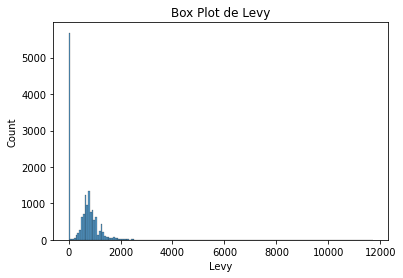

In [39]:
sns.histplot(data=processed_df, x='Levy').set(title='Box Plot de Levy')

[Text(0.5, 1.0, 'Box Plot de Levy')]

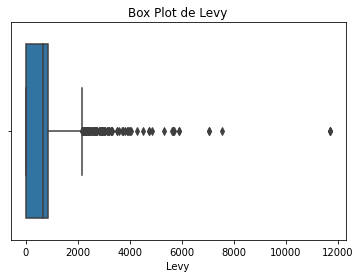

In [40]:
sns.boxplot(data=processed_df, x='Levy').set(title='Box Plot de Levy')

De acuerdo a la gráfica anterior tenemos outliers con valores altos de Levy. Para tratar de no sesgar tanto el modelo, imputaremos a estos valores la media de la columna.

In [41]:
def remove_outlier_IQR(df, column):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    return [(Q1-1.5*IQR), (Q3+1.5*IQR)]
lim_lower_outliers, lim_upper_outliers = remove_outlier_IQR(processed_df, 'Levy')
lim_upper_outliers

2155.0

In [42]:
processed_df.loc[processed_df['Levy'] >= lim_upper_outliers, 'Levy'] = processed_df['Levy'].median()

[Text(0.5, 1.0, 'Box Plot de Levy')]

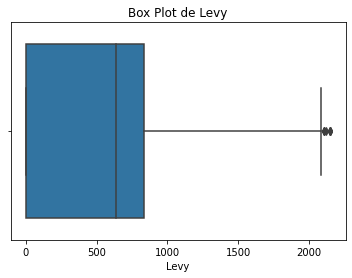

In [43]:
sns.boxplot(data=processed_df, x='Levy').set(title='Box Plot de Levy')

### Columna `Prod. year`

[Text(0.5, 1.0, 'Box Plot de Prod. year')]

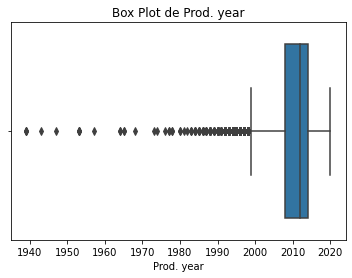

In [44]:
sns.boxplot(data=processed_df, x='Prod. year').set(title='Box Plot de Prod. year')

Como restricción de negocio tenemos que no se aceptarán datos por debajo del año de 1995, dado que la empresa está enfocada en automóviles relativamente nuevos.

In [45]:
processed_df = processed_df[processed_df['Prod. year'] > 1994]

### Columna `Mileage`

[Text(0.5, 1.0, 'Box Plot de Mileage')]

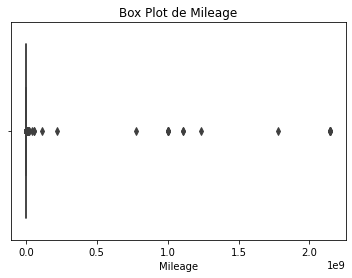

In [46]:
sns.boxplot(data=processed_df, x='Mileage').set(title='Box Plot de Mileage')

In [47]:
processed_df[processed_df['Mileage'] > 5e8]

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
985,2700,0,OPEL,Vectra,1997,Sedan,No,CNG,1.6,777777777,4.0,Automatic,Front,2,Left wheel,Beige,2
2278,6899,0,VOLKSWAGEN,Golf,1999,Sedan,No,Petrol,1.6,2147483647,4.0,Manual,Front,2,Left wheel,Black,4
5456,12544,0,NISSAN,X-Terra,2004,Jeep,No,CNG,3.3,999999999,6.0,Tiptronic,4x4,2,Left wheel,Black,8
6157,5959,0,MERCEDES-BENZ,C 180,1995,Sedan,No,CNG,1.8,2147483647,4.0,Manual,Rear,2,Left wheel,Blue,5
7724,4800,0,OPEL,Corsa,1999,Sedan,No,Petrol,1.2,1234567899,4.0,Manual,Front,2,Left wheel,Silver,2
9524,50,0,TOYOTA,Prius,2011,Hatchback,No,Hybrid,1.8,1111111111,4.0,Automatic,Front,2,Left wheel,White,6
10667,6476,0,NISSAN,Note,2008,Hatchback,No,CNG,1.5,999999999,4.0,Automatic,4x4,2,Right-hand drive,Black,0
11901,10036,0,SUBARU,Forester,2005,Jeep,No,Petrol,2.0,2147483647,4.0,Tiptronic,4x4,2,Right-hand drive,White,12
12591,2600,1529,OPEL,Vectra,1995,Sedan,No,CNG,1.8,999999999,4.0,Manual,Front,2,Left wheel,Green,4
12904,4077,0,VOLKSWAGEN,Golf,1997,Hatchback,No,CNG,1.8,999999999,4.0,Manual,Front,2,Left wheel,Carnelian red,0


In [48]:
processed_df['Mileage'].describe()

count    1.553500e+04
mean     1.716112e+06
std      5.103258e+07
min      0.000000e+00
25%      6.700000e+04
50%      1.210000e+05
75%      1.800000e+05
max      2.147484e+09
Name: Mileage, dtype: float64

De acuerdo al resultado anterior encontramos valores inusualmente altos para el kilometraje. Asimismo, tenemos valores repetidos, o con dígitos repetidos, por lo que se asumirá que es un error de digitación. \
De acuerdo con [records mileage](https://info.westerncentralny.aaa.com/blog/high-mileage-vehicles-racked-millions-miles#:~:text=1966%20Volvo%20P1800%20%2D%203%2C000%2C000%20miles,in%20his%201966%20Volvo%201800S.) el automóvil con mayor kilometraje es de 3 millones de millas, un equivalente a 4.8 millones de km. \
Asimismo, debido a que tenemos valores de 11.111.111 km de kilometraje, 
se optará por remover los valores por encima de 10 millones de km.

In [49]:
processed_df = processed_df[processed_df['Mileage'] < 1e7]
processed_df.shape

(15507, 17)

### Columna `Engine volume`

[Text(0.5, 1.0, 'Box Plot de Engine volume')]

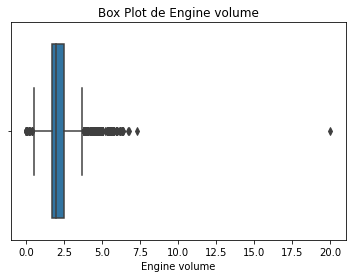

In [50]:
sns.boxplot(data=processed_df, x='Engine volume').set(title='Box Plot de Engine volume')

Imputaremos algunos valores atípicos:

In [51]:
processed_df[processed_df['Model'] == 'CLK 430']

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
1588,7213,0,MERCEDES-BENZ,CLK 430,1999,Coupe,Yes,Petrol,4.3,115000,8.0,Tiptronic,Rear,1,Left wheel,Silver,4
5367,7840,639,MERCEDES-BENZ,CLK 430,2005,Cabriolet,No,Petrol,7.3,156470,12.0,Automatic,Rear,2,Left wheel,Black,12


In [52]:
processed_df.loc[processed_df['Model'] == 'CLK 430', 'Model'] = 4.3

In [53]:
processed_df[processed_df['Engine volume'] == 20]

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2357,10036,639,HYUNDAI,Sonata,2014,Sedan,Yes,LPG,20.0,333686,4.0,Automatic,Front,2,Left wheel,Silver,4


Para el anterior modelo se asumirá un error de imputación y se dejará el Engine volume en 2.0 L.

In [54]:
processed_df.loc[processed_df['Engine volume'] >= 20, 'Engine volume'] = 2

### Columna `Cylinders`

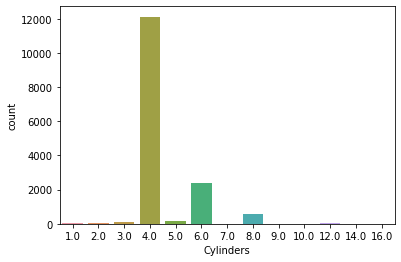

In [55]:
sns.countplot(data = processed_df, x='Cylinders')

Se analizarán las instancias con más de 10 cilindros:

In [56]:
processed_df[processed_df['Cylinders']>10].head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
115,11917,639,MERCEDES-BENZ,E 500 AMG,2003,Sedan,Yes,Petrol,5.0,150000,12.0,Tiptronic,Rear,2,Right-hand drive,White,12
322,22894,0,NISSAN,Pathfinder,2010,Sedan,No,Petrol,4.0,109100,12.0,Automatic,4x4,2,Left wheel,Blue,12
456,11604,993,OPEL,Astra,2006,Goods wagon,No,Diesel,1.3,27000,16.0,Manual,Front,2,Left wheel,Black,8
724,81539,1360,LEXUS,GX 460,2013,Jeep,Yes,Petrol,4.6,76800,12.0,Tiptronic,4x4,2,Left wheel,Black,0
820,7997,308,TOYOTA,Prius 2014,2014,Sedan,Yes,Hybrid,1.8,0,12.0,Tiptronic,Front,2,Left wheel,Black,12


Al buscar en internet para el modelo de auto LEXUS	GX 460, encontramos que cuenta con 8 cilindros, mientras en el dataset está con 12. Esto nos da indicios que los valores por encima de 10 pueden estar errados. Por tal motivo conservaremos únicamente los valores por debajo o igual a 10:

In [57]:
processed_df = processed_df[processed_df['Cylinders']<=10]
processed_df.shape

(15463, 17)

### Columna `Airbags`

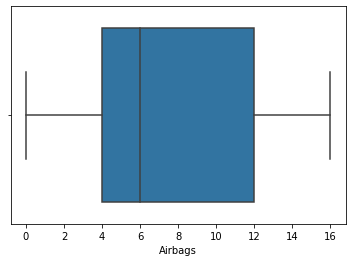

In [58]:
sns.boxplot(data = processed_df, x='Airbags')

Analizaremos los automóviles con más de 12 airbags:

In [59]:
processed_df[processed_df['Airbags']>=12].head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,2,Left wheel,Silver,12
6,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909,4.0,Automatic,Front,2,Left wheel,White,12
7,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118,4.0,Automatic,Front,2,Left wheel,Grey,12
8,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069,4.0,Automatic,Front,2,Left wheel,Black,12
9,26657,0,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500,6.0,Automatic,4x4,2,Left wheel,Silver,12


Al buscar en internet para el primer modelo de auto encontramos que cuenta con 4 airbags, lo cual nos da indicios que los valores por encima de 12 están errados. Debido a esto se optará por eliminar los datos con cantidad de airbags mayores  a 12.

In [60]:
processed_df = processed_df[processed_df['Airbags']<12]
processed_df.shape

(11413, 17)

## Transformaciones

A continuación se aplicaran las transformaciones sobre las columnas categóricas. Dado el análisis previo en la primera entrega, se encontró que todas las variables categóricas son nominales (a excepción de la variable Doors la cual se le aplicó una transformación ordinal), se les aplicará oneHot encoding (sin incluir las de mayor cardinalidad) y a un segundo dataset con las de mayor cardinalidad Binary encoding:

In [61]:
one_hot_encoding_df = clean_cars(processed_df).encode_one_hot_dataframe()
binary_encoding_df = clean_cars(processed_df).encode_binary_dataframe()

In [62]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
X_one_hot_encoding_df = one_hot_encoding_df.drop(['Price'], axis=1)
X_binary_encoding_df = binary_encoding_df.drop(['Price'], axis=1)

Y_one_hot_encoding_df = processed_df[['Price']]
Y_binary_encoding_df = processed_df[['Price']]

X_one_hot_encoding_standard_df = pd.DataFrame(standard_scaler.fit_transform(X_one_hot_encoding_df.drop(['Manufacturer', 'Model', 'Color'], axis=1)), columns = X_one_hot_encoding_df.drop(['Manufacturer', 'Model', 'Color'], axis=1).columns)
X_one_hot_encoding_min_max_df = pd.DataFrame(min_max_scaler.fit_transform(X_one_hot_encoding_df.drop(['Manufacturer', 'Model', 'Color'], axis=1)), columns = X_one_hot_encoding_df.drop(['Manufacturer', 'Model', 'Color'], axis=1).columns)

X_binary_encoding_standard_df = pd.DataFrame(standard_scaler.fit_transform(X_binary_encoding_df), columns = X_binary_encoding_df.columns)
X_binary_encoding_min_max_df = pd.DataFrame(min_max_scaler.fit_transform(X_binary_encoding_df), columns = X_binary_encoding_df.columns)

#One hot encoding
X_train_one_hot_encoding_standard, X_test_one_hot_encoding_standard, Y_train_one_hot_encoding_standard, Y_test_one_hot_encoding_standard = train_test_split(X_one_hot_encoding_standard_df, Y_one_hot_encoding_df, test_size = 0.2, random_state=1)
X_train_one_hot_encoding_standard, X_val_one_hot_encoding_standard, Y_train_one_hot_encoding_standard, y_val_one_hot_encoding_standard= train_test_split(X_train_one_hot_encoding_standard, Y_train_one_hot_encoding_standard, test_size = 0.2)

X_train_one_hot_encoding_min_max, X_test_one_hot_encoding_min_max, Y_train_one_hot_encoding_min_max, Y_test_one_hot_encoding_min_max = train_test_split(X_one_hot_encoding_min_max_df, Y_one_hot_encoding_df, test_size = 0.2, random_state=1)
X_train_one_hot_encoding_min_max, X_val_one_hot_encoding_min_max, Y_train_one_hot_encoding_min_max, y_val_one_hot_encoding_min_max= train_test_split(X_train_one_hot_encoding_min_max, Y_train_one_hot_encoding_min_max, test_size = 0.2)

#Binary encoding
X_train_binary_encoding_standard, X_test_binary_encoding_standard, Y_train_binary_encoding_standard, Y_test_binary_encoding_standard = train_test_split(X_binary_encoding_standard_df, Y_binary_encoding_df, test_size = 0.2, random_state=1)
X_train_binary_encoding_standard, X_val_binary_encoding_standard, Y_train_binary_encoding_standard, y_val_binary_encoding_standard = train_test_split(X_train_binary_encoding_standard, Y_train_binary_encoding_standard, test_size = 0.2)

X_train_binary_encoding_min_max, X_test_binary_encoding_min_max, Y_train_binary_encoding_min_max, Y_test_binary_encoding_min_max = train_test_split(X_binary_encoding_min_max_df, Y_binary_encoding_df, test_size = 0.2, random_state=1)
X_train_binary_encoding_min_max, X_val_binary_encoding_min_max, Y_train_binary_encoding_min_max, y_val_binary_encoding_min_max = train_test_split(X_train_binary_encoding_min_max, Y_train_binary_encoding_min_max, test_size = 0.2)

In [64]:
processed_df.to_csv('processed_cars.csv', index = False)

In [65]:
def generate_csv(df, name):
  df.to_csv(name+'.csv', encoding='utf-8', index=False)
#One hot encoding
generate_csv(X_train_one_hot_encoding_standard, 'X_train_one_hot_encoding_standard')
generate_csv(X_val_one_hot_encoding_standard, 'X_val_one_hot_encoding_standard')
generate_csv(X_test_one_hot_encoding_standard, 'X_test_one_hot_encoding_standard')
generate_csv(Y_train_one_hot_encoding_standard, 'y_train_one_hot_encoding_standard')
generate_csv(y_val_one_hot_encoding_standard, 'y_val_one_hot_encoding_standard')
generate_csv(Y_test_one_hot_encoding_standard, 'y_test_one_hot_encoding_standard')

generate_csv(X_train_one_hot_encoding_min_max, 'X_train_one_hot_encoding_min_max')
generate_csv(X_val_one_hot_encoding_min_max, 'X_val_one_hot_encoding_min_max')
generate_csv(X_test_one_hot_encoding_min_max, 'X_test_one_hot_encoding_min_max')
generate_csv(Y_train_one_hot_encoding_min_max, 'y_train_one_hot_encoding_min_max')
generate_csv(y_val_one_hot_encoding_min_max, 'y_val_one_hot_encoding_min_max')
generate_csv(Y_test_one_hot_encoding_min_max, 'y_test_one_hot_encoding_min_max')

#Binary encoding
generate_csv(X_train_binary_encoding_standard, 'X_train_binary_encoding_standard')
generate_csv(X_val_binary_encoding_standard, 'X_val_binary_encoding_standard')
generate_csv(X_test_binary_encoding_standard, 'X_test_binary_encoding_standard')
generate_csv(Y_train_binary_encoding_standard, 'Y_train_binary_encoding_standard')
generate_csv(y_val_binary_encoding_standard, 'y_val_binary_encoding_standard')
generate_csv(Y_test_binary_encoding_standard, 'Y_test_binary_encoding_standard')

generate_csv(X_train_binary_encoding_min_max, 'X_train_binary_encoding_min_max')
generate_csv(X_val_binary_encoding_min_max, 'X_val_binary_encoding_min_max')
generate_csv(X_test_binary_encoding_min_max, 'X_test_binary_encoding_min_max')
generate_csv(Y_train_binary_encoding_min_max, 'y_train_binary_encoding_min_max')
generate_csv(y_val_binary_encoding_min_max, 'y_val_binary_encoding_min_max')
generate_csv(Y_test_binary_encoding_min_max, 'y_test_binary_encoding_min_max')

## Anexo: Distribuciones entre los conjuntos de entrenamiento

Como las variantes de los conjuntos de entrenamiento anteriores corresponden a un mismo conjunto pero con transformaciones diferentes, se analizará por simplicidad una sóla variante, en este caso one_hot_encoding con transformación estándar.

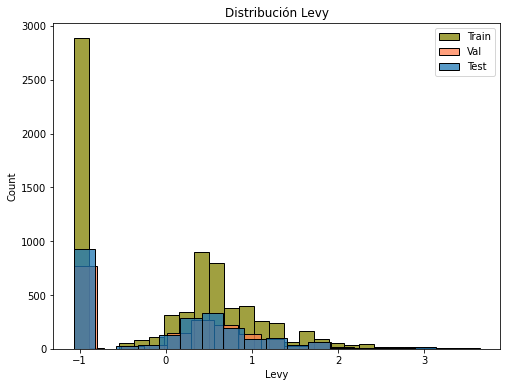

In [74]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard.Levy, color="olive")
sns.histplot(X_val_one_hot_encoding_standard.Levy, color="coral")
sns.histplot(X_test_one_hot_encoding_standard.Levy)
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Levy')
plt.title('Distribución Levy');

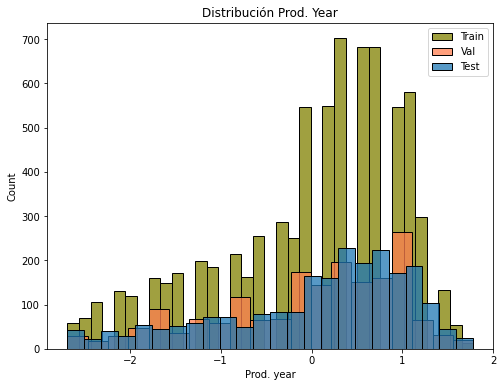

In [75]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Prod. year'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Prod. year'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Prod. year'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Prod. year')
plt.title('Distribución Prod. Year');

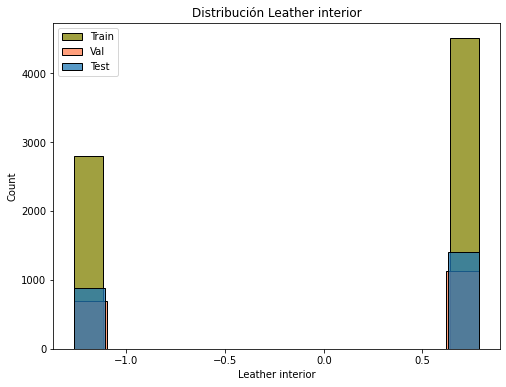

In [80]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Leather interior'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Leather interior'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Leather interior'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Leather interior')
plt.title('Distribución Leather interior');

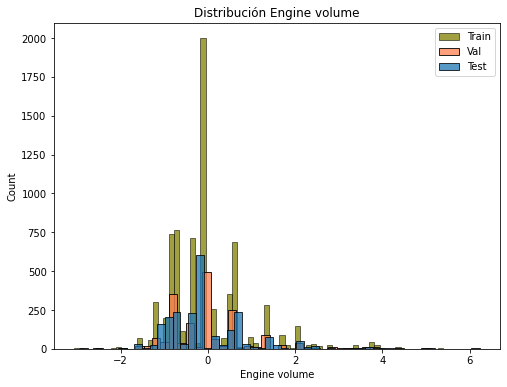

In [81]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Engine volume'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Engine volume'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Engine volume'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Engine volume')
plt.title('Distribución Engine volume');

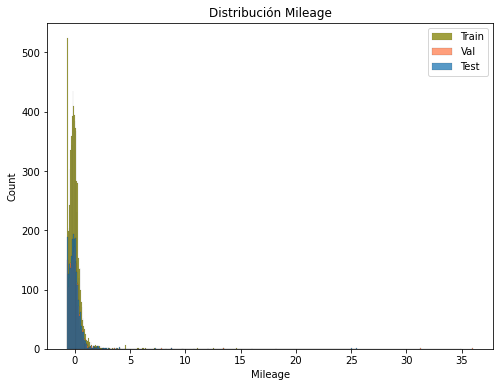

In [82]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Mileage'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Mileage'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Mileage'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Mileage')
plt.title('Distribución Mileage');

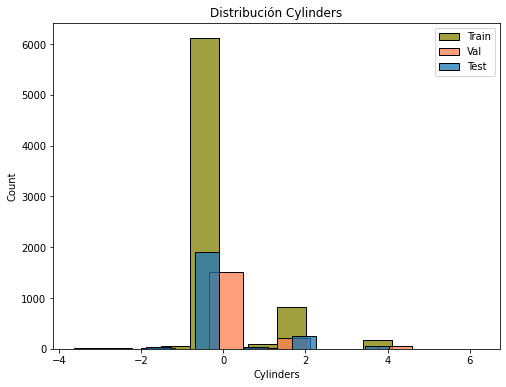

In [83]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Cylinders'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Cylinders'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Cylinders'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Cylinders')
plt.title('Distribución Cylinders');

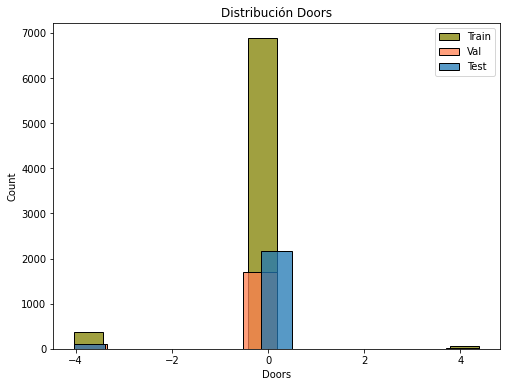

In [85]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Doors'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Doors'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Doors'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Doors')
plt.title('Distribución Doors');

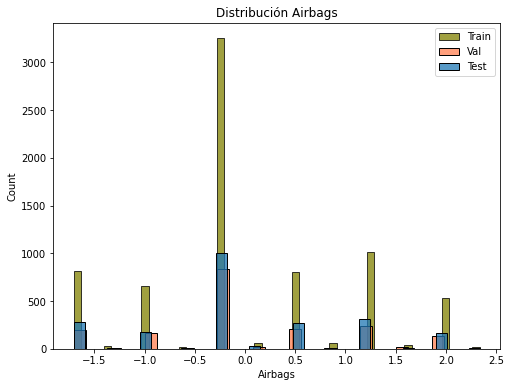

In [86]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(X_train_one_hot_encoding_standard['Airbags'], color="olive")
sns.histplot(X_val_one_hot_encoding_standard['Airbags'], color="coral")
sns.histplot(X_test_one_hot_encoding_standard['Airbags'])
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Airbags')
plt.title('Distribución Airbags');